# Lending Tree Data

This is a quick demo of the Lending Tree P2P loan data.  There are many possibilities to explore with this data set, but there is one I'm particularly interested in.

1) Using machine learning, how well can we predict whether loans will default or not?

2) Given an algorithm's accuracy, what is an optimal investing strategy as a function of risk?

3) How do the above results compare to human performance on the site?  How do they compare against the automated investing on certain sites?

4) Lending Tree and other P2P lending sites offer most of the same information, but there are some differences! For example, Prosper  gives access to credit bureau underwriting data through their API, which is a huge chunk of information).

I plan to compare:
- Lending Tree
- Prosper
- Funding Circle (if their public API is released by June)


This data was downloaded from https://www.lendingclub.com/info/download-data.action
For future work, current data will be fetched using their API to augment this data, as described here:
https://www.lendingclub.com/developers/lc-api.action

Last updated 2016.04.08 by Stinnett

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Display plots inline, use a nicer style.
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Import all data at once. Not necessarily the best practice, but this is only ~700MB. Approximately a 60s runtime.
file_prefix='./Data_Project/LendingClub/LoanStats3'
data_a=pd.read_csv(file_prefix+'a.csv',delimiter=',',low_memory=False) # 2007-2011
data_b=pd.read_csv(file_prefix+'b.csv',delimiter=',',low_memory=False) # 2012-2013
data_c=pd.read_csv(file_prefix+'c.csv',delimiter=',',low_memory=False) # 2013-2014
data_d=pd.read_csv(file_prefix+'d.csv',delimiter=',',low_memory=False) # 2015

# For the exploratory stats in this notebook, 
data=pd.concat([data_a,data_b,data_c,data_d])

# Go ahead and remove the invididual sets from memory. 
%reset_selective -f data_a 
%reset_selective -f data_b
%reset_selective -f data_c
%reset_selective -f data_d

In [3]:
# There are actually three sheets in this file, but only one we care about currently.
data_description=pd.ExcelFile('./Data_Project/LendingClub/LCDataDictionary.xlsx')
data_description=data_description.parse('LoanStats')


Process the data slightly to make it easier to use.

In [4]:
# Process the data some to make analysis simpler throughout.

# Convert the int_rate from a string to a float.

def convert_percentage(interest):
    '''
    Convert the int_rate to a float.
    Input:
        interest: a string, ending with '%'
    Output:
        out: a float, converted to a decimal or nan if input is nan
        
    Example: interest='10.6%' will yield 0.106   
             interest=nan     will yield nan
    '''
    try:
        out=interest[0:-1] 
        return float(out)/100.
    except:
        return np.nan
    
data['int_rate']=data['int_rate'].apply(convert_percentage)

# Do the same thing for 'revol_util'
data['revol_util']=data['revol_util'].apply(convert_percentage)

# Change the term from a string (e.g. '36 months') to an integer (number of months)
def fix_term(term):
    '''
    Convert the term to an int of months instead of a string.
    Input: 
        term: string, e.g. '36 months'
    Output:
        an integer of the number of months
    '''
    try:
        out=term.split()[0]
        return int(out)
    except:
        return np.nan
data['term']=data['term'].apply(fix_term)

# toss out rows with nan int_rates
data=data[np.isfinite(data['int_rate'])]

# Convert home_ownership to 0 or 1
def fix_home(homeownership):
    if homeownership=='RENT':
        return -1
    elif homeownership=='MORTAGE':
        return 0
    else:
        return 1
        
data['home_ownership']=data['home_ownership'].apply(fix_home)

# Add a grade column where the grades are numbers.  This will be used for the random forest classifier later.
def grade_number(grade):
    if grade=='A':
        return 0
    elif grade=='B':
        return 1
    elif grade=='C':
        return 2
    elif grade=='D':
        return 3
    elif grade=='E':
        return 4
    elif grade=='F':
        return 5
    elif grade=='G':
        return 6
    else:
        return np.nan
    
data['grade_n']    =data['grade'].apply(grade_number)    
print('Data Processed')

Data Processed


Let's look at an example row (out of the ~900k rows), ignoring any blank columns for now (many columns are mostly unpopulated).

In [5]:
data.head(3).dropna(axis=1)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,grade_n
0,1077501,1296599,5000,5000,4975,36,0.1065,162.87,B,B2,...,Mar-2016,0,1,INDIVIDUAL,0,0,0,0,0,1
1,1077430,1314167,2500,2500,2500,60,0.1527,59.83,C,C4,...,Sep-2013,0,1,INDIVIDUAL,0,0,0,0,0,2
2,1077175,1313524,2400,2400,2400,36,0.1596,84.33,C,C5,...,Mar-2016,0,1,INDIVIDUAL,0,0,0,0,0,2


First, just go get a feel for the grading, let's look the interest rate vs grade.

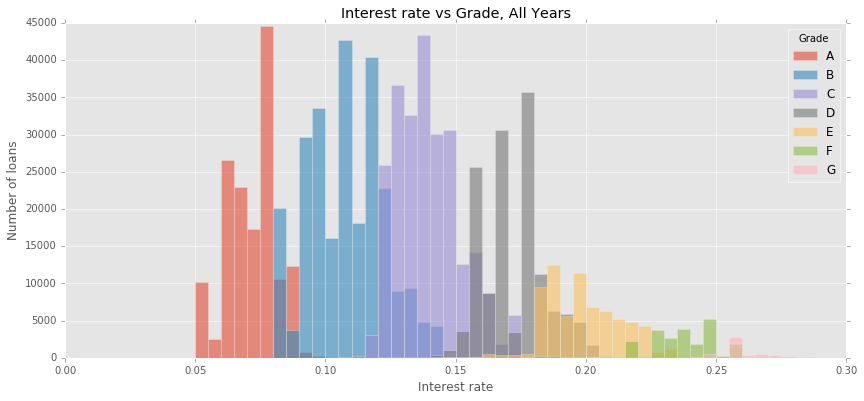

In [6]:
# Let's just deal with a piece of the whole data frame
tmp=data[['grade','sub_grade','int_rate']].dropna(how='all',axis=0)

# Plot the interest rates, grouped by grade
groups = tmp.groupby('grade')['int_rate']
fig, ax = plt.subplots()

for k, v in groups:
    v.hist(label=k, alpha=.6, ax=ax,figsize=(14,6),bins=[0.005*i for i in range(60)])

ax.legend(title='Grade')
ax.set_xlabel('Interest rate')
ax.set_ylabel('Number of loans')
ax.set_title('Interest rate vs Grade, All Years')

So it seems that each grade has about a 5% window for its interest rate.  Within a grade, what determines the interest rate? 

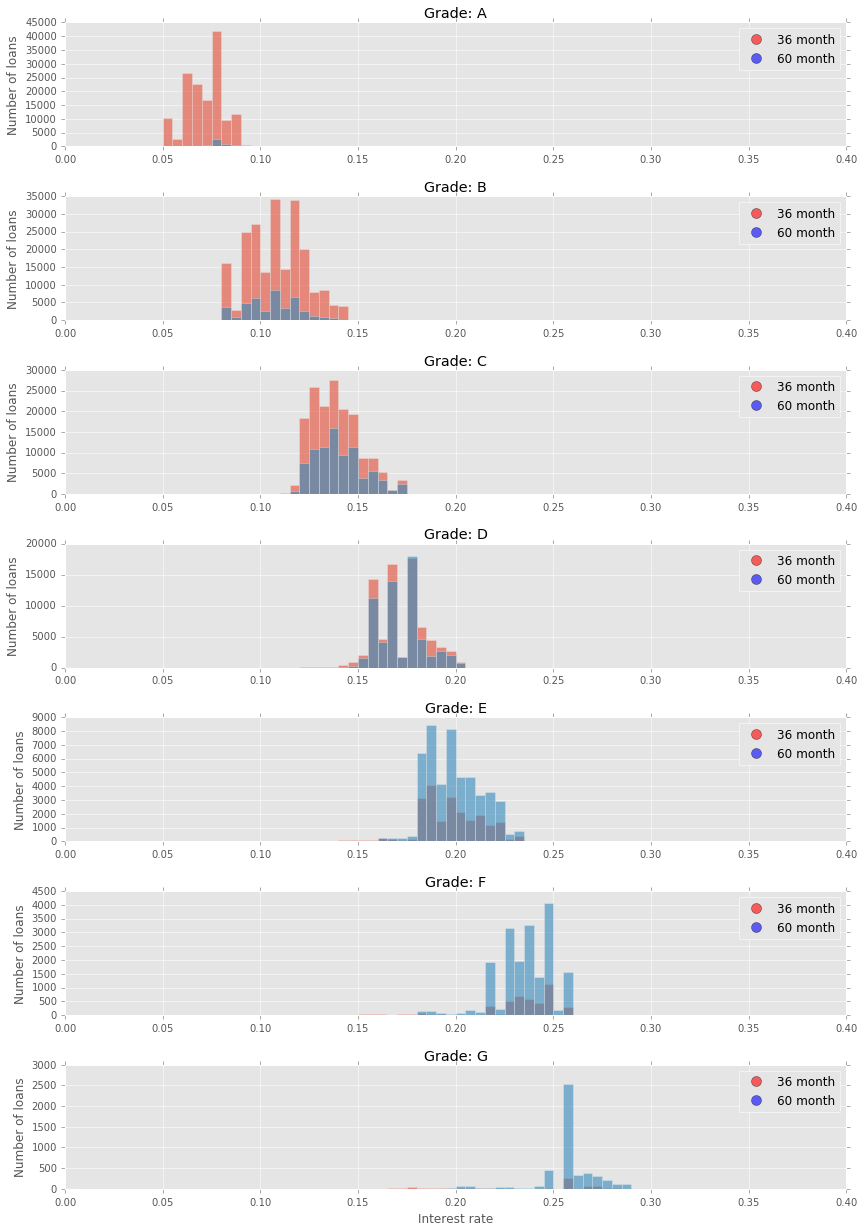

In [7]:
# First idea: loan term.
tmp=data[['grade','loan_amnt','term','int_rate']]
grades=data['grade'].unique()

# Initialize plots, adjust geometry.
fig,ax=plt.subplots(7,1)
plt.subplots_adjust(left=None, bottom=-2.5, right=None, top=.2, wspace=None, hspace=.4)


# Make a custom legend as a workaround for a labeling issue
rect1 = plt.Line2D([0], [0], linestyle="none", marker="o", alpha=.6, markersize=10, markerfacecolor="red")
rect2 = plt.Line2D([0], [0], linestyle="none", marker="o", alpha=.6, markersize=10, markerfacecolor="blue")

# Iteratively plot.
current_plot=-1
for grade in np.sort(grades):
    current_plot=current_plot+1
    tmp=data[data['grade']==grade]
    
    # Plot the interest rates, grouped by term length
    groups = tmp.groupby('term')['int_rate']
    cur_set=1
    for k, v in groups:
        ax[current_plot]=v.hist(alpha=.6,
                                ax=ax[current_plot],
                                figsize=(14,6),
                                bins=[0.005*i for i in range(80)]
                               )
        ax[current_plot].set_title('Grade: '+grade)
        #ax[current_plot].set_ylim((0,45000))
        ax[current_plot].set_ylabel('Number of loans')
        cur_set=cur_set+1
        #ax[current_plot].legend(title='Term')      
        ax[current_plot].legend((rect1,rect2), ("36 month", "60 month"), numpoints=1, loc="best")

ax[current_plot].set_xlabel('Interest rate')
plt.savefig('InterestGradeTerm.jpg', format='jpg')

### Interestingly, while term length does not appear to be a predictor of interest rates, worse grades (higher letter) are clearly significantly more likely to take out a 60 month loan than the better grades. It's not the correlation we were looking for though.
Note that the figures above do NOT have the same y-scale: Grades E F and G are much less well represented here.

How about we look at amount?  Do larger loans have greater interest? Instead of plotting, let's look at Pearson's correlation relative to int_rate for several variables at once.

Note: home ownership was mapped earlier by RENT= -1, MORTGAGE=0, OWN=1.  A much better map for future analysis would be to declare rent, mortgage, ownership, etc boolean variables.  The current map is enough to notice the slight relation below.



In [8]:
data[['int_rate','loan_amnt','revol_util','home_ownership','total_acc']].corr().iloc[0:1,:]


,int_rate,loan_amnt,revol_util,home_ownership,total_acc
int_rate,1,0.145002,0.269137,-0.06153,-0.038607


The above results aren't really surprising.  

- People with a larger revolving line utilization rate (% of their credit in use) tend to get a higher interest rate
- People that rent tend to get slightly worse interest rates
- Larger loans tend to have a larger interest rate.

And so on.  While none of these correlations are particularly large, they may be larger within certain groups (e.g. maybe Grade C, slightly higher interest folks rely more on credit card usage, etc). However, this won't really be captured by Pearson's correlation, since the interest rates don't vary very much within a grade. We can look anyway to see why this isn't a very useful statistic within a grade:

In [9]:
for grade in np.sort(grades):
    result=data[data['grade']==grade][['int_rate','loan_amnt','revol_util','home_ownership','total_acc']].corr().iloc[0:1,:]
    print('Grade= '+str(grade))
    print(result)

Grade= A
          int_rate  loan_amnt  revol_util  home_ownership  total_acc
int_rate         1   0.025261    0.207913       -0.056829  -0.047271
Grade= B
          int_rate  loan_amnt  revol_util  home_ownership  total_acc
int_rate         1   -0.04415    0.118233       -0.038203  -0.045073
Grade= C
          int_rate  loan_amnt  revol_util  home_ownership  total_acc
int_rate         1   0.039916    0.091638         0.01579   0.006493
Grade= D
          int_rate  loan_amnt  revol_util  home_ownership  total_acc
int_rate         1   0.037735    0.088359       -0.000694   0.005154
Grade= E
          int_rate  loan_amnt  revol_util  home_ownership  total_acc
int_rate         1   0.058342    0.077614        0.007349   0.020316
Grade= F
          int_rate  loan_amnt  revol_util  home_ownership  total_acc
int_rate         1   0.026171   -0.042022         0.00086   0.011117
Grade= G
          int_rate  loan_amnt  revol_util  home_ownership  total_acc
int_rate         1   0.098794   -0.17570

## Finally, let's look at the actual status of the loans.  
There are a few values for 'loan_status':
1. 'Fully Paid': 
2. 'Charged Off'
3. 'Current'
4. 'In Grace Period
5. 'Late (16-30 days)'
6. 'Late (31-120 days)'
7. 'Default'
8. 'Does not meet the credit policy. Status:Fully Paid'
9. 'Does not meet the credit policy. Status:Charged Off'

Let's look at the defaulted and charged off loans.

In [10]:
data['loan_status'].value_counts(normalize=True)

Current                                                0.646175
Fully Paid                                             0.268607
Charged Off                                            0.060401
Late (31-120 days)                                     0.012778
In Grace Period                                        0.006024
Late (16-30 days)                                      0.002589
Does not meet the credit policy. Status:Fully Paid     0.002240
Does not meet the credit policy. Status:Charged Off    0.000858
Default                                                0.000328
Name: loan_status, dtype: float64

In [11]:
def filter_badloans(loan_status):
    '''
    Filter to keep only the bad loans (charged off or defaulted).
    '''
    if loan_status=='Default' or loan_status=='Charged Off' or loan_status=='Does not meet the credit policy. Status:Charged Off':
        return True
    else:
        return False
def filter_goodloans(loan_status):
    '''
    Filter to keep only the bad loans (charged off or defaulted).
    '''
    if loan_status=='Default' or loan_status=='Charged Off' or loan_status=='Does not meet the credit policy. Status:Charged Off':
        return False
    else:
        return True
    
    
tmp=data[data['loan_status'].apply(filter_badloans)]

# See what we are working with now
tmp['loan_status'].value_counts()

Charged Off                                            53599
Does not meet the credit policy. Status:Charged Off      761
Default                                                  291
Name: loan_status, dtype: int64

In [12]:
# Is there a difference in average loan amounts between good and bad loans? (No)
tmp_bad =data[data['loan_status'].apply(filter_badloans)]
tmp_good=data[data['loan_status'].apply(filter_goodloans)]
(tmp_good['loan_amnt'].mean()-tmp_bad['loan_amnt'].mean())/tmp_good['loan_amnt'].mean()

0.010247957427401155

In [13]:
# Q) Do people whose loans go bad have a higher credit utilization?
# A) Slightly; their average utilization is about 4.3% higher total.
(tmp_bad['revol_util'].mean()-tmp_good['revol_util'].mean())

0.04364957565912497

In [14]:
# Q) Do people whose loans go bad have more or less accounts total?
# A) They have about one less account on average.
(tmp_bad['total_acc'].mean()-tmp_good['total_acc'].mean())

-0.9919062489146704

In [15]:
tmp_bad.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,home_ownership,annual_inc,dti,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,grade_n
count,54651.000000,54651.000000,54651.000000,54651.000000,54651.000000,54651.000000,54651.000000,54651.000000,54651.000000,54651.000000,...,43792.000000,43783.000000,46554.000000,54317.000000,54640.000000,43792.000000,47102.000000,47102.000000,43792.000000,54651.000000
mean,15157081.635231,14613.291614,14571.247553,14422.767926,44.663995,0.160029,441.828689,0.059121,65602.696612,18.605005,...,2.286057,94.985908,57.105538,0.106689,0.029996,138728.701315,44198.589444,16972.456605,36195.366049,2.483742
std,15394686.331552,8401.034903,8379.353459,8432.432778,11.527077,0.042901,246.972799,0.998260,55386.871968,8.039253,...,1.743120,7.750484,33.894836,0.331218,0.260782,140873.425433,40069.689717,16535.108478,36816.016249,1.376899
min,70694.000000,500.000000,500.000000,0.000000,36.000000,0.053200,15.910000,-1.000000,2000.000000,0.000000,...,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2167037.500000,8000.000000,8000.000000,8000.000000,36.000000,0.130500,266.180000,-1.000000,40266.640000,12.710000,...,1.000000,92.600000,33.300000,0.000000,0.000000,40833.500000,19829.000000,6300.000000,12006.750000,1.000000
50%,9341236.000000,12800.000000,12700.000000,12450.000000,36.000000,0.156100,390.830000,1.000000,56326.000000,18.510000,...,2.000000,100.000000,60.000000,0.000000,0.000000,83473.000000,34225.500000,12100.000000,27638.000000,2.000000
75%,22681881.500000,20000.000000,20000.000000,20000.000000,60.000000,0.188500,573.795000,1.000000,79521.500000,24.340000,...,3.000000,100.000000,87.500000,0.000000,0.000000,200933.500000,55643.750000,22100.000000,48987.000000,3.000000
max,70731192.000000,35000.000000,35000.000000,35000.000000,60.000000,0.289900,1424.570000,1.000000,8706582.000000,39.990000,...,25.000000,100.000000,100.000000,5.000000,9.000000,3867129.000000,1896461.000000,326300.000000,589699.000000,6.000000


# A very basic prediction scheme: random forest classification

Prepare a training and test data set.

In [16]:
cols=['grade_n','loan_amnt','int_rate','annual_inc','tot_hi_cred_lim','loan_status']
#cols=['grade_n','loan_amnt','term','home_ownership','dti','int_rate','annual_inc','tot_hi_cred_lim','loan_status']
scheme_data=data[cols]

# Create a boolean bad_loan column
pd.options.mode.chained_assignment = None  # default='warn'
scheme_data['bad']=scheme_data['loan_status'].apply(filter_badloans)

#drop na values
scheme_data=scheme_data.dropna(axis=0) # removes about 70k of 880k entries

# drop the other loan column out
scheme_data=scheme_data.drop('loan_status',1)

#separate into training and test data
# pick n_test values to use as a test set.  use the rest as a training set.
# Make a random list.

x=np.arange(scheme_data.shape[0])
x=np.random.choice(x,size=len(x),replace=False)

n_test=50000
test_data =scheme_data.iloc[x[0:n_test]][['grade_n','loan_amnt','int_rate','annual_inc','tot_hi_cred_lim']]
test_label =scheme_data.iloc[x[0:n_test]][['bad']]['bad'].values
train_data=scheme_data.iloc[x[n_test:]][['grade_n','loan_amnt','int_rate','annual_inc','tot_hi_cred_lim']]
train_label=scheme_data.iloc[x[n_test:]][['bad']]['bad'].values

In [17]:
# Import the random forest package
from sklearn.ensemble import RandomForestClassifier 

# Define an evaluation function.
def evaluate_forest(output,test_label):
    '''
    Evaluate the performance of the random forest.  
    Compares the predicted labels vs the actual labels in the test set.
    
    Output: three printed lines.
    1. [accuracy at identifying bad (true) loans, accuracy at identifying false (good) loans]
    2. # bad loans identified correctly / # of bad loans total
    3. # good loans identified correctly / # of good loans total
    
    '''
    false_correct=0
    false_wrong=0
    true_correct=0
    true_wrong=0
    for i in range(n_test):
        if output[i]==False: #says it is a good loan
            if test_label[i]==False: # correct
                false_correct=false_correct+1
            else:
                false_wrong=false_wrong+1
        else: 
            if test_label[i]==True:
                true_correct=true_correct+1
            else: 
                true_wrong=true_wrong+1

    true_accuracy=true_correct/float(true_correct+true_wrong)
    false_accuracy=false_correct/float(false_correct+false_wrong)
    print([true_accuracy,false_accuracy])
    
    print('True: ' +str(true_correct)+'/'+str(true_correct+false_wrong))
    print('False: '+str(false_correct)+'/'+str(false_correct+true_wrong))
    return np.array([true_accuracy,false_accuracy])

def randomforest(train_data,train_label,test_data,test_label,nestimators):
    '''
    Use a random forest classifier on the training data.  Only prints out accuracy results.
    '''
    # Create the forest.
    forest = RandomForestClassifier(n_estimators = nestimators)

    # Create the decision trees
    forest = forest.fit(train_data.values,train_label)

    # Run on test set
    output = forest.predict(test_data)

    # Evaluate
    out=evaluate_forest(output,test_label)
    return out

In [18]:
# Run the random forest classifier for 75 estimators.  
# The best results I've gotten so far with this is [.23, .95], with 75 estimators.

randomforest(train_data,train_label,test_data,test_label,75)

[0.18867924528301888, 0.9493388976946691]
True: 30/2555
False: 47316/47445


array([ 0.18867925,  0.9493389 ])

# PCA
How well can the data be split?  This is only using some of the data set (the same columns were used for the random forest classifier). 

In [19]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [20]:
pca=PCA(n_components=3)
pca.fit(train_data)
print(pca.explained_variance_ratio_)

[ 0.90101743  0.09724696  0.0017356 ]


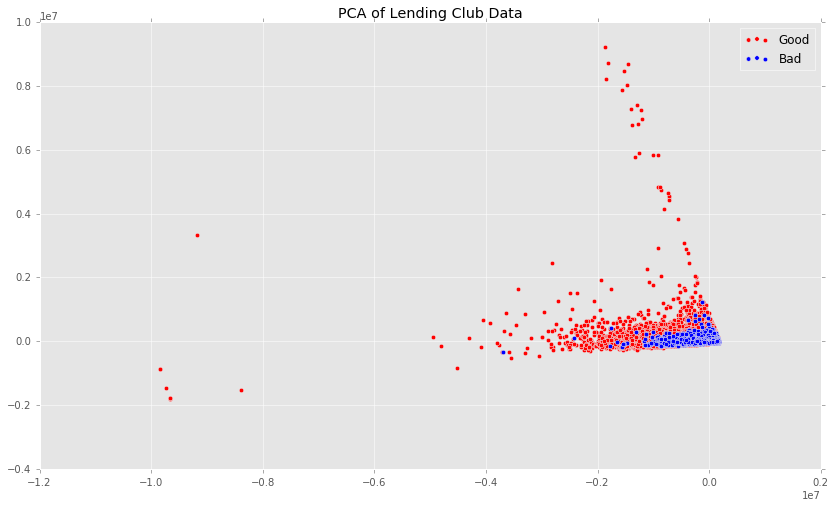

In [21]:
#X = train_data.values
X = train_data
y = train_label


pca = PCA(n_components=3)


X_r = pca.fit(X).transform(X)


ax=plt.figure(figsize=(14,8))
target_names=np.array(['Good','Bad'])
for c, i, target_name in zip("rb", [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], c=c, label=target_name)
    
    
plt.legend()
plt.title('PCA of Lending Club Data')

plt.show()

It is not surprising that the random forest classifier performed poorly.  At least with this slice of the data, it isn't exactly separable.  With future work, I will run this on the full-dimensioned data set.